In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
def plot_embeddings_1000G_labels(emb, labels, palette, label_order, ax):
    
    sns.scatterplot(x=emb[:,0],
                    y=emb[:,1],
                    ax=ax,
                    palette=palette,
                    hue_order=label_order,
                    hue=pd.Categorical(labels))
    ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')

    for label in np.unique(labels):
        index = label == labels
        mean_pos = emb[index,:2].mean(0)
        ax.text(x=mean_pos[0], 
                y=mean_pos[1], 
                s=label)

def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

In [5]:
# Load MHI
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/MHI'
fname = 'gsa.17k/SGR-2227_MHI_biobank_GSAv3.0MD_609343_SNPs_16707_ids_2021-01-04.WR_hg38-updated.missing10perc.noMAF0.common1000G.noHLA.raw.cols1and7toend.hdf5'
metadata_file = 'MHI_poplabels.tsv'

with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs_mhi = hf['inputs'][:]
    class_label_names_mhi = hf['class_label_names'][:]
    class_labels_mhi = hf['class_labels'][:]
    samples_mhi = hf['samples'][:]
    snp_names_mhi = hf['snp_names'][:]

samples_mhi = np.char.decode(samples_mhi)

In [6]:
metadata_labels = pd.read_csv(os.path.join(exp_path, metadata_file), sep='\t')

In [7]:
# Set the 'ID' column as the index
metadata_labels_indexed = metadata_labels.set_index('ID')

# remove labels that dont appear in df
intersection = metadata_labels_indexed.index.isin(samples_mhi.tolist()) 
metadata_labels_indexed = metadata_labels_indexed[intersection]

# remove samples in df that dont appear in labels
intersection2 = pd.DataFrame(samples_mhi)[0].isin(metadata_labels_indexed.index)
samples_mhi = samples_mhi[intersection2]
inputs_mhi = inputs_mhi[intersection2]

# Reorder the DataFrame based on id_reorder
metadata_labels_reordered = metadata_labels_indexed.loc[samples_mhi.tolist()]

In [8]:
import sklearn
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs_mhi)

In [9]:
def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

label_order_mhi, pop_pallette_mhi = make_palette_order(metadata_labels_reordered)

In [10]:
np.unique(metadata_labels_reordered['selfreported_pop'], return_counts=True)

(array(['Asian', 'Black', 'Caucasian', 'Hispanic', 'Native', 'NotDone'],
       dtype=object),
 array([   66,   126, 16349,   118,     9,     4]))

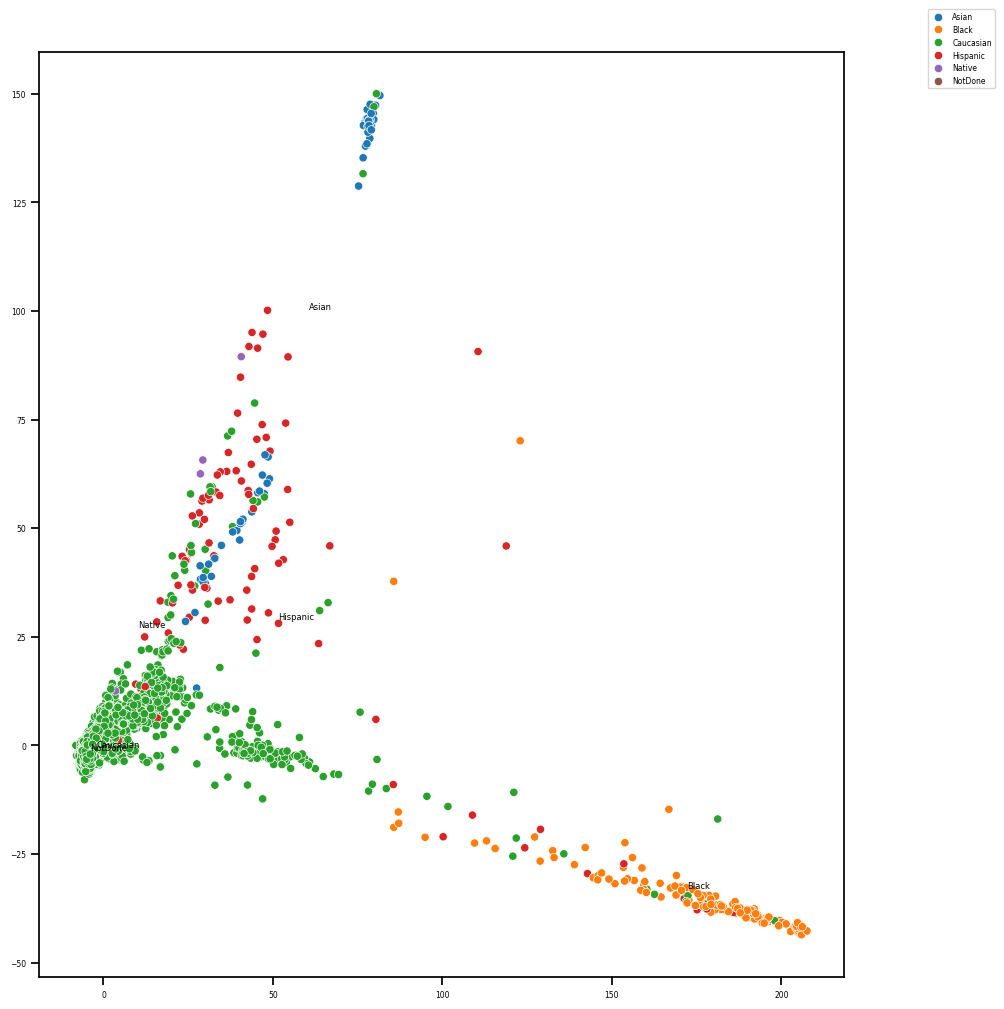

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
plot_embeddings_1000G_labels(pca_input, 
                             metadata_labels_reordered['selfreported_pop'], 
                             pop_pallette_mhi,
                             label_order_mhi,
                             ax)
plt.tight_layout()

In [12]:
# initial phate embedding
phate_operator = phate.PHATE(random_state=42, knn=5, decay=60, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

Running PHATE on 16672 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 22.78 seconds.
  Calculating affinities...
  Calculated affinities in 3.30 seconds.
Calculated graph and diffusion operator in 26.10 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 1.20 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.54 seconds.
Calculated landmark operator in 4.71 seconds.
Calculating optimal t...
  Automatically selected t = 18
Calculated optimal t in 3.52 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.72 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.50 seconds.


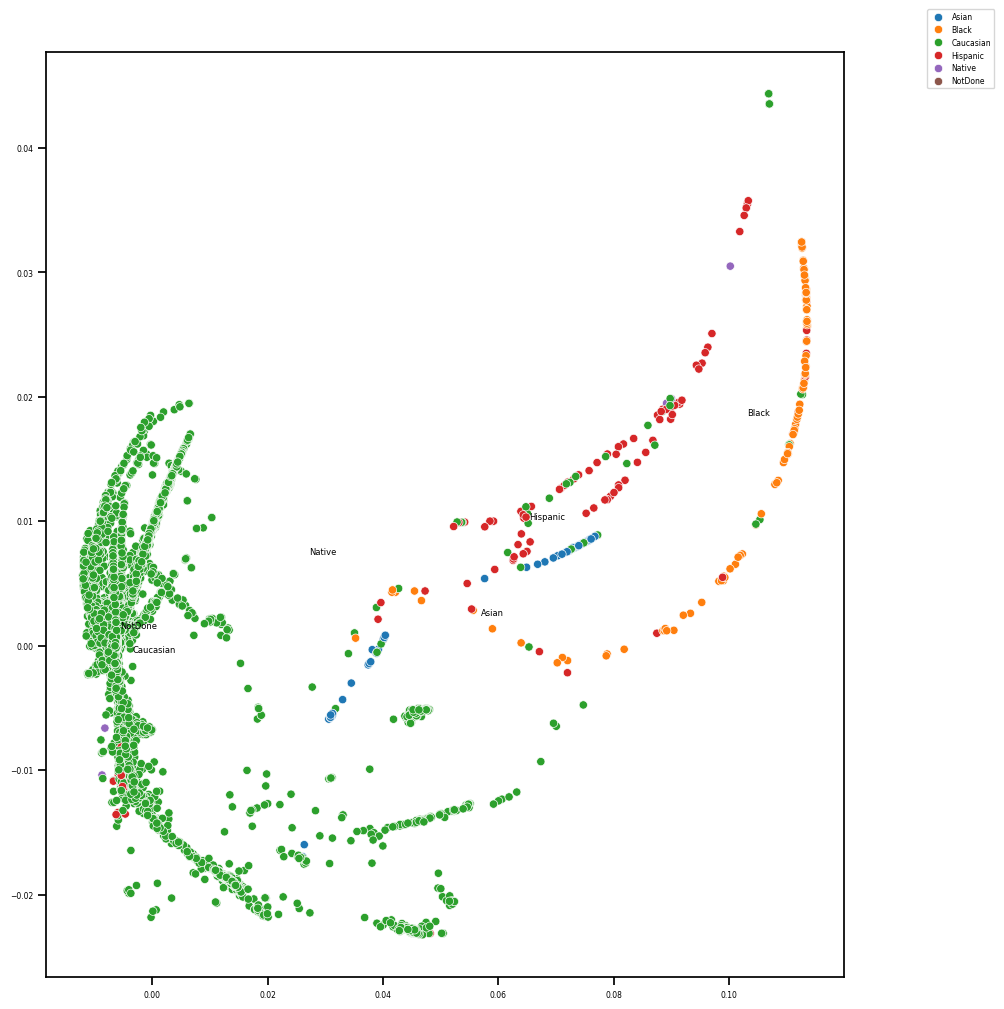

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
plot_embeddings_1000G_labels(phate_emb, 
                             metadata_labels_reordered['selfreported_pop'], 
                             pop_pallette_mhi,
                             label_order_mhi,
                             ax)
plt.tight_layout()

Running PHATE on 16672 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 22.49 seconds.
  Calculating affinities...
  Calculated affinities in 3.03 seconds.
Calculated graph and diffusion operator in 25.54 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 1.10 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.12 seconds.
Calculated landmark operator in 4.20 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.04 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.38 seconds.


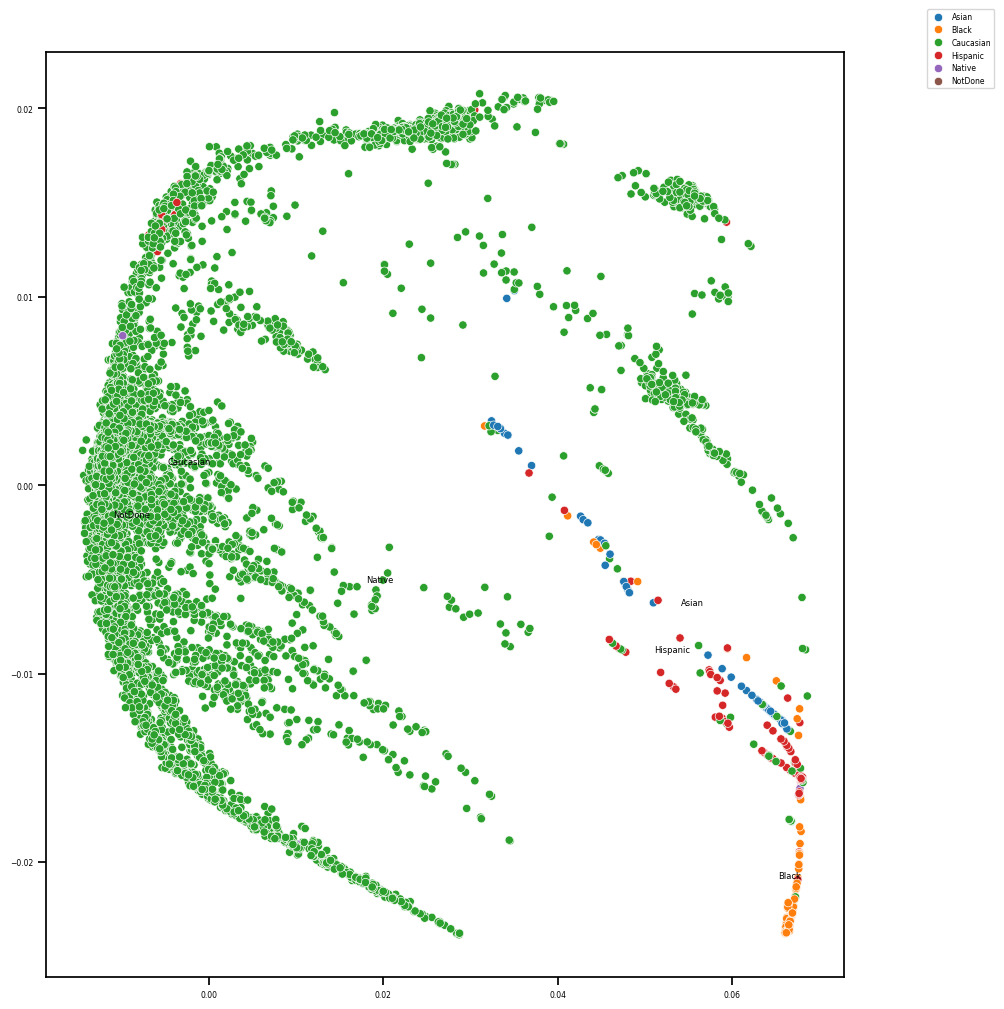

In [16]:
# smaller t
phate_operator = phate.PHATE(random_state=42, knn=5, decay=60, t=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

fig, ax = plt.subplots(figsize=(10,10))
plot_embeddings_1000G_labels(phate_emb, 
                             metadata_labels_reordered['selfreported_pop'], 
                             pop_pallette_mhi,
                             label_order_mhi,
                             ax)
plt.tight_layout()

Running PHATE on 16672 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 27.35 seconds.
  Calculating affinities...
  Calculated affinities in 1.43 seconds.
Calculated graph and diffusion operator in 29.02 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 8.02 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.62 seconds.
Calculated landmark operator in 15.63 seconds.
Calculating optimal t...
  Automatically selected t = 10
Calculated optimal t in 3.20 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.37 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.36 seconds.


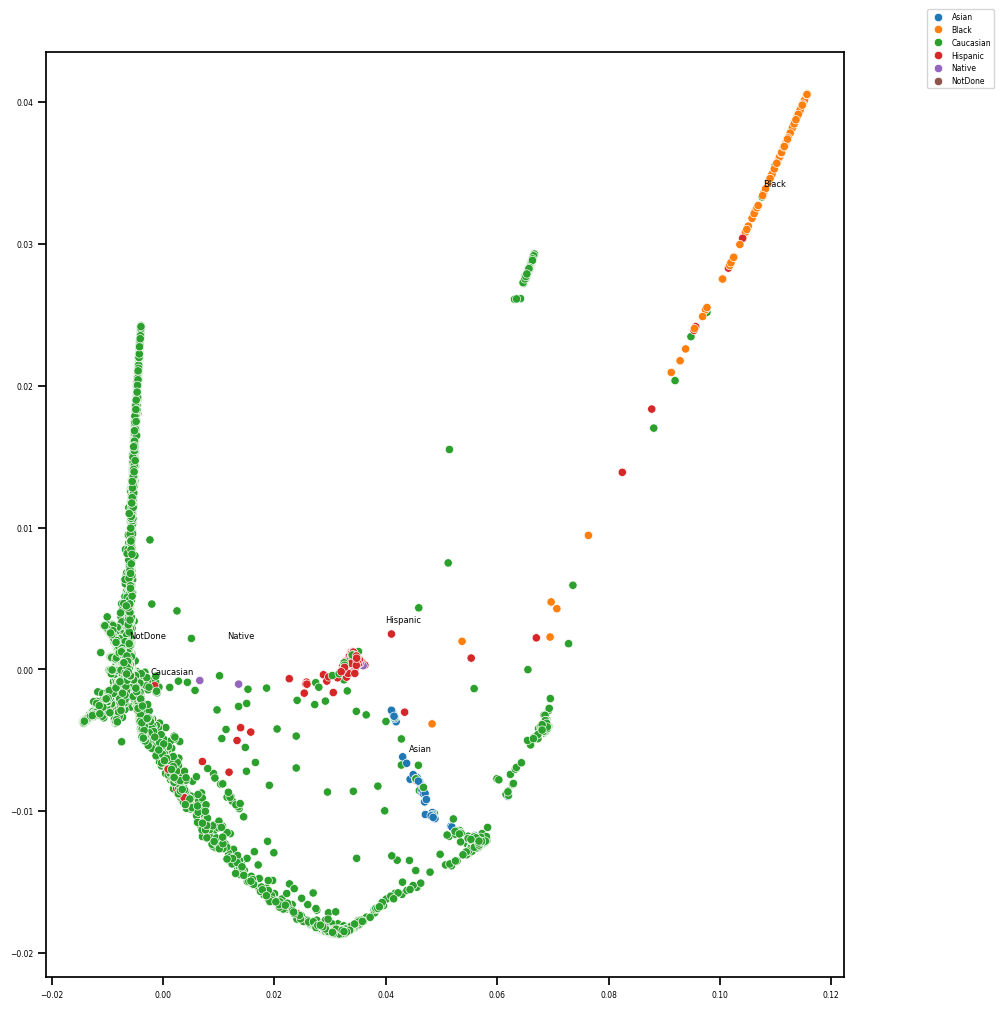

In [17]:
# big knn phate embedding
phate_operator = phate.PHATE(random_state=42, knn=100, decay=60, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

fig, ax = plt.subplots(figsize=(10,10))
plot_embeddings_1000G_labels(phate_emb, 
                             metadata_labels_reordered['selfreported_pop'], 
                             pop_pallette_mhi,
                             label_order_mhi,
                             ax)
plt.tight_layout()

Running PHATE on 16672 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 31.54 seconds.
  Calculating affinities...
  Calculated affinities in 1.96 seconds.
Calculated graph and diffusion operator in 33.93 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 14.53 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.92 seconds.
Calculated landmark operator in 23.99 seconds.
Calculating optimal t...
  Automatically selected t = 6
Calculated optimal t in 3.46 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.04 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.40 seconds.


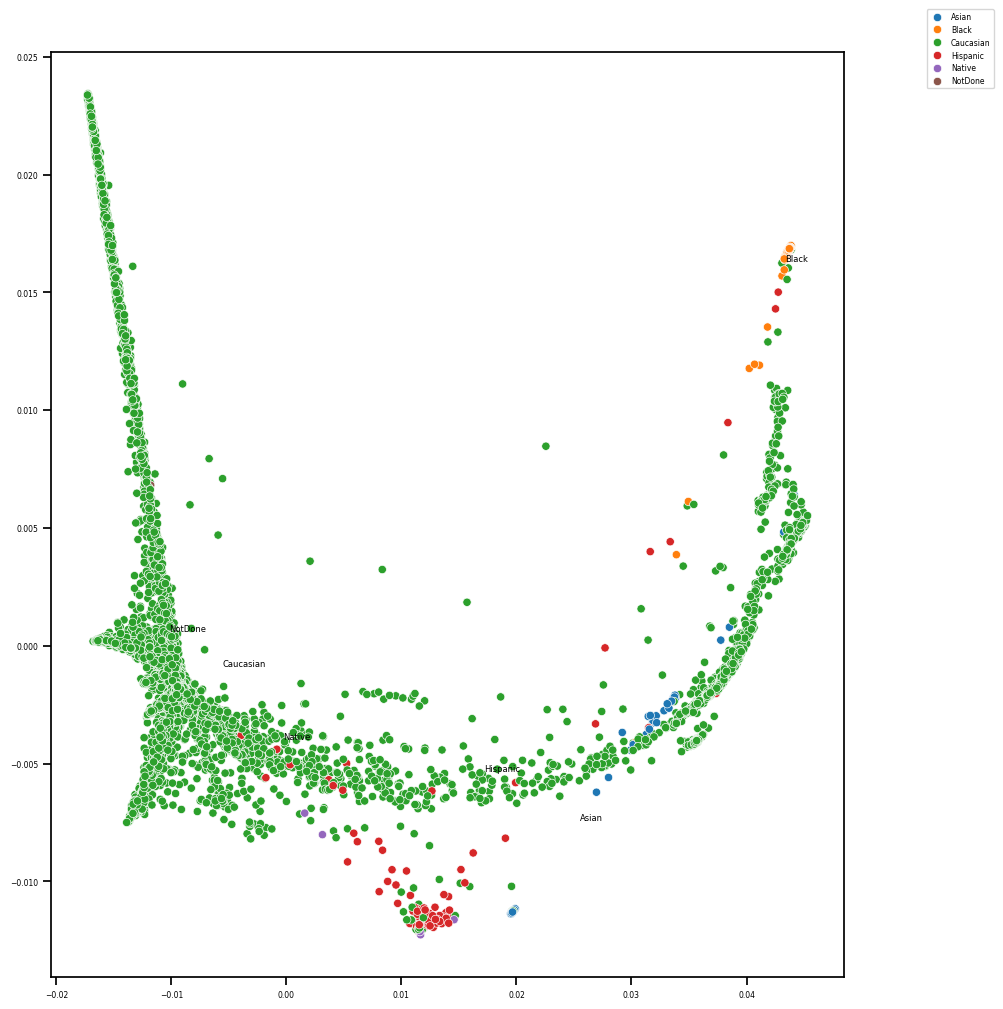

In [15]:
# big knn phate embedding
phate_operator = phate.PHATE(random_state=42, knn=200, decay=60, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

fig, ax = plt.subplots(figsize=(10,10))
plot_embeddings_1000G_labels(phate_emb, 
                             metadata_labels_reordered['selfreported_pop'], 
                             pop_pallette_mhi,
                             label_order_mhi,
                             ax)
plt.tight_layout()